In [66]:
import xgboost as xgb
import pickle
import pandas as pd
import itertools
import numpy as np
import seaborn as sns
from lazypredict.Supervised import LazyRegressor
import matplotlib.pyplot as plt
import sklearn.preprocessing as skp
import sklearn.metrics as skm
import sklearn.ensemble as ske
import sklearn.model_selection as sms
import sklearn.linear_model as skl

%matplotlib inline

In [3]:
data_test = pd.read_csv("../data/prepared_test.csv", sep=";", index_col=0).sort_index()
data_test.head()

,dteday,season,yr,mnth,holiday,workingday,temp,atemp,hum,windspeed,...,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,weathersit_1,weathersit_2,weathersit_3
instant,,,,,,,,,,,,,,,,,,,,,
7,07.01.2011,1,0,1,0,1,7.86,0.21,74.80,0.17,...,0,0,0,0,0,1,0,0,1,0
11,11.01.2011,1,0,1,0,1,6.76,0.19,102.95,0.12,...,0,0,1,0,0,0,0,0,1,0
14,14.01.2011,1,0,1,0,1,6.43,0.19,80.67,0.13,...,0,0,0,0,0,1,0,1,0,0
16,16.01.2011,1,0,1,0,0,9.27,0.23,72.56,0.19,...,1,0,0,0,0,0,0,1,0,0
18,18.01.2011,1,0,1,0,1,8.67,0.23,129.25,0.15,...,0,0,1,0,0,0,0,0,1,0


In [4]:
data_train = pd.read_csv("../data/prepared_train.csv", sep=";", index_col=0
                         ).sort_index()
data_train.head()

,dteday,season,yr,mnth,holiday,workingday,temp,atemp,hum,windspeed,...,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,weathersit_1,weathersit_2,weathersit_3
instant,,,,,,,,,,,,,,,,,,,,,
1,01.01.2011,1,0,1,0,0,13.77,0.36,120.87,0.16,...,0,0,0,0,0,0,1,0,1,0
2,02.01.2011,1,0,1,0,0,14.54,0.35,104.41,0.25,...,1,0,0,0,0,0,0,0,1,0
3,03.01.2011,1,0,1,0,1,7.85,0.19,65.59,0.25,...,0,1,0,0,0,0,0,1,0,0
4,04.01.2011,1,0,1,0,1,8.00,0.21,88.57,0.16,...,0,0,1,0,0,0,0,1,0,0
5,05.01.2011,1,0,1,0,1,9.08,0.23,65.54,0.19,...,0,0,0,1,0,0,0,1,0,0


## Initial Model Selection ##

In [5]:
#multicolinear = ["mnth", "temp", "hum", "leaflets"]
multicolinear = ["hum", "temp"]
# features = ('season',
#  'yr',
#  'atemp',
#  'weekday_0',
#  'weekday_1',
#  'weekday_2',
#  'weathersit_1',
#  'weathersit_3')

In [6]:
scaler = skp.StandardScaler()
data_features = data_train.drop(
    columns=["dteday", "casual", "registered", "cnt", *multicolinear]).columns.to_list()

X_train = scaler.fit_transform(X=data_train[data_features], y=data_train["cnt"])

Y_train = data_train["cnt"].copy()

X_test = scaler.transform(data_test[data_features])

Y_test = data_test["cnt"].copy()

Für die Auswahl des Modelltyps verwenden wird die Bibliothek `lazypredict`. Sie erstellt 42 Regressionsmodelle verschiendener Typen mithilfe unseres Datensatzes.

In [7]:
reg = LazyRegressor(verbose=0, ignore_warnings=True, predictions=True)
models, pred = reg.fit(X_train, X_test, Y_train, Y_test)

 98%|█████████▊| 41/42 [00:04<00:00, 11.71it/s]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000789 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 645
[LightGBM] [Info] Number of data points in the train set: 592, number of used features: 17
[LightGBM] [Info] Start training from score 4455.685811
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

100%|██████████| 42/42 [00:04<00:00,  9.35it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


In diesem DataFrame sind die Metriken der jeweiligen Modelltypen zu sehen. Zu erkennen ist, dass der Typ `GradientBoostingRegressor` nach allen Metriken die höchste Genuigkeit erzielt. Weitere gut abschneidende Modelltypen sind der `XGBRegressor` und der `ExtraTreesRegressor`. Für das Parametertuning werden alle drei Typen näher betrachtet, das es sein könnte, dass eines der drei Modelle deutlich besser abschneidet, sobald die Hyperparameter angepasst werden.

In [8]:
models

,Adjusted R-Squared,R-Squared,RMSE,Time Taken
Model,,,,
GradientBoostingRegressor,0.85,0.87,693.50,0.21
XGBRegressor,0.83,0.85,745.62,0.13
ExtraTreesRegressor,0.83,0.85,753.89,0.43
HistGradientBoostingRegressor,0.82,0.85,756.70,0.94
LGBMRegressor,0.81,0.84,782.32,0.23
RandomForestRegressor,0.81,0.83,797.18,0.74
BaggingRegressor,0.80,0.83,812.77,0.10
AdaBoostRegressor,0.75,0.79,903.69,0.14
LassoCV,0.74,0.78,924.94,0.06


Auf dieser Grafik ist ein Vergleich zwischen tatsächlichen und vorhergesagten Daten des `GradientBoostingRegressor` zu sehen. Es ist zu erkennen, dass es einige Ausreißer nach unten gibt, die das Modell nicht abbilden konnte. Bei dem Wert am rechten Ende des GRaph konnte das Modell dies jedoch sehr gut.

In [9]:
def actualVsPredictChart(true_v, pred_v):
    data = {"Actual": true_v, "Predicted": pred_v}
    df = pd.DataFrame(data)

    # Create a lineplot with Seaborn
    sns.set(style="whitegrid")
    plt.figure(figsize=(10, 6))

    sns.lineplot(data=df, markers=False)

    plt.title("Actual vs. Predicted Values")
    plt.xlabel("Data Points")
    plt.ylabel("Values")

    plt.show()

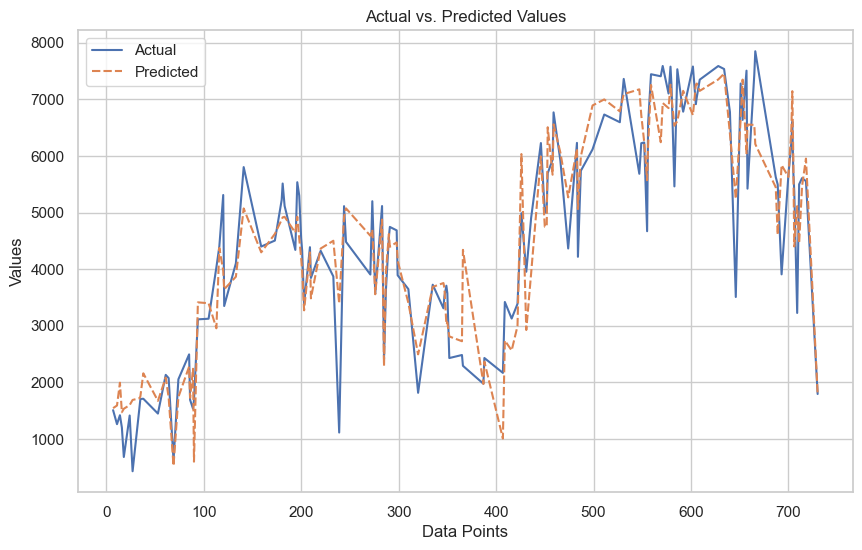

In [10]:
actualVsPredictChart(Y_test, pred["GradientBoostingRegressor"].to_numpy())

#### Hyperparameter ####
- GradientBoostingRegressor
- XGBRegressor
- ExtraTressRegressor

Hier werden alle Hyperparameter definiert. Die Listen enthalten die möglichen Werte eines jeden Parameters. Jedes Modell hat verschiedene Hyperarameter.

In [21]:
gbRegressor = {
    "loss": ['quantile'],#'squared_error', 'absolute_error', 'huber', 
    "alpha":[0.2*x for x in range(1, 5)],
    "criterion": ['friedman_mse', 'squared_error'],
    "learning_rate": [0.1*x for x in range(-2, 3)],
    "max_depth": [None, 5, 10],
    "n_estimators": [50, 100, 200]
}

xgbRegressor = {
    "n_estimators": [50, 100, 200],
    "max_depth": [None, 5, 10],
    "max_leaves": [0, 5, 10, 20],
    "learning_rate": [0.2*x for x in range(1, 5)],
    "booster": ["gbtree", "gblinear", "dart"],
    "grow_policy": [0, 1],
    "gamma": [1e-3, 1e-1, 1],
    "reg_alpha": [1e-3, 1e-1, 1],
    "reg_lambda": [1e-3, 1e-1, 1],
    "metric": [skm.mean_absolute_error]
}

etRegressor = {
    "n_estimators": [50, 100, 200],
    "criterion": ["squared_error", "absolute_error", "friedman_mse", "poisson"],
    "max_features": ["sqrt", "log2"],
    "max_depth": [None, 3, 5, 10]
}

features = {
    ske.GradientBoostingRegressor: gbRegressor,
    xgb.XGBRegressor: xgbRegressor,
    ske.ExtraTreesRegressor: etRegressor
}

In [22]:
model_select_results = pd.DataFrame(columns=["model", "params", "mae"])
for model_type in features:
    gs_model = sms.GridSearchCV(estimator=model_type(),
                                param_grid=features[model_type],
                                n_jobs=-1,
                                scoring='neg_mean_absolute_error')
    
    gs_model.fit(X_train, Y_train)
    print(f"Model type {str(model_type)}\nreached MAE of {gs_model.best_score_*-1}\n Params: {gs_model.best_params_}")
    model_select_results.loc[len(model_select_results)] = [gs_model.best_estimator_, gs_model.best_params_, gs_model.best_score_*-1]

model_select_results.sort_values("mae", inplace=True)

Model type <class 'sklearn.ensemble._gb.GradientBoostingRegressor'>
reached MAE of 713.7971896514825
 Params: {'alpha': 0.6000000000000001, 'criterion': 'friedman_mse', 'learning_rate': 0.1, 'loss': 'quantile', 'max_depth': 5, 'n_estimators': 200}
Model type <class 'xgboost.sklearn.XGBRegressor'>
reached MAE of 743.1116456025686
 Params: {'booster': 'gblinear', 'gamma': 0.001, 'grow_policy': 0, 'learning_rate': 0.2, 'max_depth': None, 'max_leaves': 0, 'metric': <function mean_absolute_error at 0x000001D11FB4E480>, 'n_estimators': 100, 'reg_alpha': 0.001, 'reg_lambda': 0.1}
Model type <class 'sklearn.ensemble._forest.ExtraTreesRegressor'>
reached MAE of 912.511353226036
 Params: {'criterion': 'absolute_error', 'max_depth': None, 'max_features': 'sqrt', 'n_estimators': 50}


In [51]:
model_select_results

,model,params,mae
0,([DecisionTreeRegressor(criterion='friedman_ms...,"{'alpha': 0.6000000000000001, 'criterion': 'fr...",713.80
1,"XGBRegressor(base_score=None, booster='gblinea...","{'booster': 'gblinear', 'gamma': 0.001, 'grow_...",743.11
2,(ExtraTreeRegressor(criterion='absolute_error'...,"{'criterion': 'absolute_error', 'max_depth': N...",912.51


In [52]:
model_select_results.loc[0, "params"]

{'alpha': 0.6000000000000001,
 'criterion': 'friedman_mse',
 'learning_rate': 0.1,
 'loss': 'quantile',
 'max_depth': 5,
 'n_estimators': 200,
 'n_jobs': -1}

In [53]:
type(model_select_results.loc[0, "model"])()

GradientBoostingRegressor()

## Feature Selection ##

In [129]:
# Falls bereits ausgeführt, kann die Datei geladen werden
feature_results = pickle.load(open("feature_results.pkl", "rb"))

Diese Funktion gibt alle möglichen, einzigartigen Kombinationen der unabhängigen Variablen aus. Die Liste enthält die höchste Anzahl an Features zu Beginn und wird danach immer kürzer (Backward Eliminiation).

In [112]:
def get_feature_combinations(features):
    all_combinations = []
    for r in range(1, len(features) + 1):
        combinations = itertools.combinations(features, r)
        all_combinations.extend(combinations)

    # Backwards Elimination
    return all_combinations[::-1]

In [113]:
X_train = data_train[data_features]
X_test = data_test[data_features]
Y_train = data_train["cnt"]
Y_test = data_test["cnt"]

Funktion zur Evaluation einer Feature-Kombination mittels MAE, R², etc.

In [114]:
def eval_model_params(features):

    # Refit scaler
    scaler.fit(X_train.loc[:, features])

    reg = skl.Ridge(random_state=1)
    reg.fit(scaler.transform(X_train.loc[:, features]), Y_train)

    # Model scores
    sc = sc = reg.score(scaler.transform(X_train.loc[:, features]), Y_train)
    y_pred = reg.predict(scaler.transform(X_test.loc[:, features]))
    r2 = skm.r2_score(Y_test, y_pred)
    rmse = np.sqrt(skm.mean_squared_error(Y_test, y_pred))
    mae = skm.mean_absolute_error(Y_test, y_pred)
    coefs = reg.coef_
    reg

    return dict(features=features,
                coefs=coefs,
                score=sc,
                r2=r2,
                rmse=rmse,
                mae=mae)

Vorgehensweise:
- Es wird über alle möglichen Feature-Kombinationen iteriert und ein `Ridge`-Regressionsmodell erstellt. `Ridge` wird verwendet, da die normale Regression Probleme mit overfitting verursacht.
- Die verwendeten Features, die Koeffizienten, sowie mehrere Modellmetriken werden in einem DataFrame gespeichert.

In [115]:
###########################
# Takes 45-60 minutes to run #
###########################

feature_results = [{"mae": 0}] # Fehlermeldung vermeiden

c = 0
for feature_comb in get_feature_combinations(data_features):
    feature_results.append(eval_model_params(feature_comb))

    c+=1

    print(f"Evaluating {len(feature_comb)}/{len(data_features)} feature combinations (No. {c}) - MAE: {feature_results[-1]['mae']}", end="\r")

feature_results.remove({"mae": 0})

In [116]:
feature_results = pd.DataFrame(feature_results).sort_values("mae").dropna()

Ausführungsergebnisse speichern

In [128]:
# file = open("feature_results.pkl", "wb")
# pickle.dump(feature_results, file)

Eigenschaften der besten Modelle, sortiert nach dem MAE. Jede Zeile in dem DataFrame ist das Ergebnis eines Modells mit einer einzigartigen Feature-Kombination.

In [117]:
feature_results

,features,coefs,score,r2,rmse,mae
256181,"(season, yr, mnth, workingday, atemp, price re...","[547.0513302753793, 1007.2456938311208, -90.63...",0.78,0.78,922.32,654.42
161893,"(season, yr, mnth, workingday, atemp, price re...","[547.1964834816453, 1007.1772477214251, -90.96...",0.78,0.78,921.35,654.42
162406,"(season, yr, mnth, workingday, atemp, leaflets...","[546.9472687925077, 1006.9923562438985, -90.78...",0.78,0.78,922.41,654.46
86641,"(season, yr, mnth, workingday, atemp, leaflets...","[547.0853895574764, 1006.9042444419166, -91.13...",0.78,0.78,921.43,654.48
86396,"(season, yr, mnth, workingday, atemp, leaflets...","[517.4993170267768, 1002.9556463585066, -57.70...",0.80,0.78,924.50,654.79
...,...,...,...,...,...,...
508826,"(windspeed, leaflets, weekday_1, weekday_2, we...","[-509.59986982577016, -94.21932144417775, -77....",0.08,-0.01,1959.37,1651.43
524132,"(weekday_1, weekday_2)","[-88.28946785566983, -25.112758531697885]",0.00,-0.01,1963.01,1651.67
519375,"(weekday_1, weekday_2, weekday_3, weekday_6)","[-98.17679657710657, -34.90226940944352, -4.19...",0.00,-0.01,1961.84,1651.81
523211,"(weekday_1, weekday_2, weekday_3)","[-86.84074350436106, -23.67836677680019, 7.191...",0.00,-0.01,1962.76,1652.03


Features des besten Modells

In [135]:
feature_results.iat[0, 0]

('season',
 'yr',
 'mnth',
 'workingday',
 'atemp',
 'price reduction',
 'weekday_1',
 'weekday_5',
 'weekday_6',
 'weathersit_3')

Um die Koeffizienten den jeweiligen Features zuordnen zu können, erstellen wir dafür ein separates DataFrame. Die Koeffizienten sind deshalb wichtig, da sie aussagen, wie wichtig ein Feature für eine genaue Vorhersage ist. Da die Daten bereits skaliert sind, sind alle Werte im Bereich [-1;1] und es gibt keine Gewichtungsunterschiede zwischen den Features

In [125]:
reg_dicts = []

for idx, row in feature_results.iterrows():
    reg_dicts.append({key: value for key, value in zip(row["features"], row["coefs"])})
coef_df = pd.DataFrame(data=reg_dicts)
coef_df

,season,yr,mnth,workingday,atemp,price reduction,weekday_1,weekday_5,weekday_6,weathersit_3,weekday_4,leaflets,weathersit_1,weathersit_2,weekday_0,weekday_3,holiday,windspeed,weekday_2
0,547.05,1007.25,-90.63,144.35,995.14,48.82,-85.85,27.95,102.39,-381.93,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,547.20,1007.18,-90.96,140.06,995.16,48.78,-82.42,31.80,103.06,-381.05,12.11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,546.95,1006.99,-90.79,144.43,995.25,49.09,-85.84,28.09,102.56,-382.06,NaN,-2.98,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,547.09,1006.90,-91.13,140.11,995.27,49.07,-82.39,31.98,103.24,-381.18,12.18,-3.21,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,517.50,1002.96,-57.70,167.66,973.07,NaN,-77.01,34.51,116.06,NaN,12.19,2.80,1226.88,901.94,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
524282,NaN,NaN,NaN,NaN,NaN,NaN,-77.36,NaN,-30.41,NaN,NaN,-94.22,NaN,NaN,NaN,NaN,NaN,-509.60,-29.30
524283,NaN,NaN,NaN,NaN,NaN,NaN,-88.29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-25.11
524284,NaN,NaN,NaN,NaN,NaN,NaN,-98.18,NaN,-45.19,NaN,NaN,NaN,NaN,NaN,NaN,-4.20,NaN,NaN,-34.90
524285,NaN,NaN,NaN,NaN,NaN,NaN,-86.84,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.19,NaN,NaN,-23.68


Durchschnittliche Koeffizienten der jeweiligen Features im `Ridge`-Regressionsmodell

In [121]:
coef_df.describe().round(2).T.sort_index()

,count,mean,std,min,25%,50%,75%,max
atemp,262144.00,1057.90,66.53,944.71,1000.32,1053.26,1111.64,1220.72
holiday,262144.00,-119.17,29.80,-201.94,-139.14,-120.29,-100.34,6.33
leaflets,262144.00,-39.31,48.56,-127.95,-83.64,-38.46,2.49,64.84
mnth,262144.00,110.85,293.28,-353.21,-167.58,67.31,349.41,579.36
price reduction,262144.00,44.90,11.16,-3.19,38.13,46.30,53.33,68.21
season,262144.00,642.73,205.09,321.74,468.47,591.91,827.73,997.12
weathersit_1,262144.00,593.81,443.94,197.33,297.13,394.86,638.26,1699.46
weathersit_2,262144.00,45.45,539.98,-436.01,-322.44,-198.67,95.48,1276.05
weathersit_3,262144.00,-396.31,69.58,-582.39,-443.28,-392.41,-347.73,-227.03
weekday_0,262144.00,-53.30,90.00,-200.75,-104.95,-77.30,-44.21,313.90


Erkenntnisse:
- Je höher die gefühlte Temperatur, desto mehr Kunden pro Tag
- An Feiertagen gibt es durchschnittlich 120 Kunden weniger
- Werbeblätter senken die tägliche Kundenzahl gering (<40)
- Je später im Jahr, desto mehr Kunden gibt es täglich (110/Monat) (Kundenzuwachs?)
- Eine Preisreduktion hat nur wenig Einfluss (+50)
- Die Jahreszeit hat einen bemerkenswerten Einfluss (~640/Jahresquartal)
- Bei gutem Wetter gibt es täglich 600 Kunden mehr
- Bei mäßigem Wetter bleibt die Kundenzahl beinahe neutral (+45)
- Bei schlechtem Wetter sind die Anzahl der Kunden (-400)
- Von Montag bis Mittwoch gibt es weniger Kunden, als gegen Ende der Woche
- Die Windgeschwindigkeit beeinflusst die Kundenanzahl negativ
- An Werktagen sind im Schnitt 140 Kunden mehr unterwegs
- Im Folgejahr gibt es etwa 1000 mehr Kunden (Kundenzuwachs)

## Final Model ##

**Modelltyp**
- `sklearn.ensemble.GradientBoostingRegressor`

**Hyperparameter**
- Alpha: `0.6`
- Messkriterium: `friedman_mse`
- Lernrate: `0.1`
- Loss: `quantile`
- Maximale Baumtiefe: `5`
- Anzahl Regressoren: `200`
- (CPU-Kerne zu verwenden: `-1` (alle))

**Unabhängige Variablen / Features**
- `season`
- `yr`
- `mnth`
- `workingday`
- `atemp`
- `price reduction`
- `weekday_1`
- `weekday_5`
- `weekday_6`
- `weathersit_3`

In [141]:
fin_params = {'alpha': 0.6000000000000001,
    'criterion': 'friedman_mse',
    'learning_rate': 0.1,
    'loss': 'quantile',
    'max_depth': 5,
    'n_estimators': 200}

fin_features = ('season',
    'yr',
    'mnth',
    'workingday',
    'atemp',
    'price reduction',
    'weekday_1',
    'weekday_5',
    'weekday_6',
    'weathersit_3')

In [138]:
X_train = scaler.fit_transform(data_train[data_features])
X_test = scaler.transform(data_test[data_features])
Y_train = data_train["cnt"]
Y_test = data_test["cnt"]

In [142]:
fin_model = ske.GradientBoostingRegressor(**fin_params)

fin_model.fit(X_train, Y_train)

y_pred = fin_model.predict(X_test)

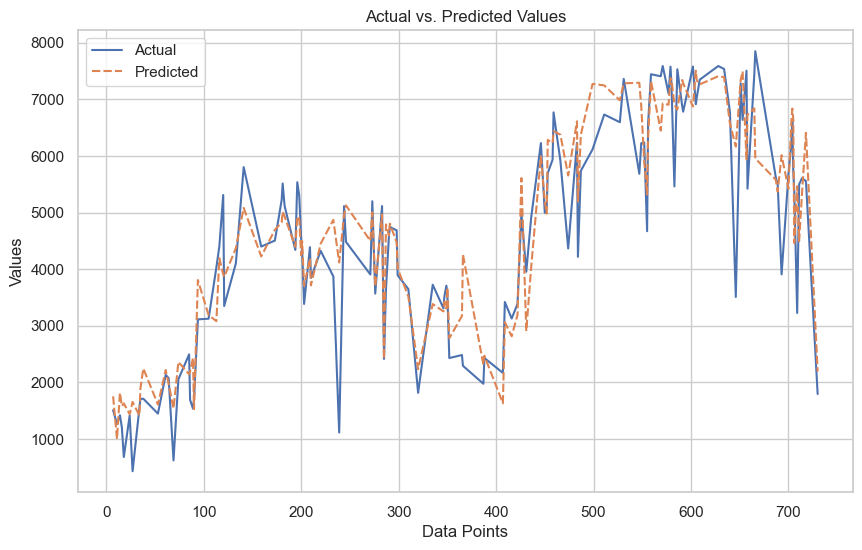

In [143]:
actualVsPredictChart(Y_test, y_pred)